<h1>Problem Definition & Objectives</h1>

<h2>Objectives</h2>
<ul>
    <li>Build a trading algorithm using the optimal combination of Indicators </li>
    <li>Backtest the strategy on historical stock data and compare its performance with the S&P 500</li>
</ul>
<h2>Key Goals</h2>
<ul>
    <li>Develop a trading startegy that balances return and risk.</li>
    <li>Ensure the startegy is scalable, modular, and adheres to industry standards.</li>
</ul>

<h2>Optimal Indicator Combination</h2>

Feature Engineering to get the importance.

<h3>Data Ingestion for Optimal Indicator</h3>

In [2]:
import yfinance as yf
import pandas as pd

def fetch_data(ticker, start_date, end_date):
    """
    Fetch historical data using Yahoo Finance.
    
    Parameters:
        ticker (str): The stock ticker symbol (e.g., 'AAPL').
        start_date (str): The start date for the data in 'YYYY-MM-DD' format.
        end_date (str): The end date for the data in 'YYYY-MM-DD' format.
    
    Returns:
        pd.DataFrame: The historical data.
    """
    return yf.download(ticker, start=start_date, end=end_date)

In [3]:
df = fetch_data('NVDA', '2010-01-01', '2024-09-09')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,0.462750,0.465500,0.452750,0.462250,0.423952,800204000
2010-01-05,0.460500,0.474000,0.460500,0.469000,0.430143,728648000
2010-01-06,0.468750,0.473000,0.464250,0.472000,0.432894,649168000
2010-01-07,0.469500,0.471500,0.459250,0.462750,0.424410,547792000
2010-01-08,0.459000,0.467000,0.456250,0.463750,0.425328,478168000
...,...,...,...,...,...,...
2024-08-30,119.529999,121.750000,117.220001,119.370003,119.359795,333751600
2024-09-03,116.010002,116.209999,107.290001,108.000000,107.990761,477155100
2024-09-04,105.410004,113.269997,104.120003,106.209999,106.200912,372470300


<h3>Define Indicators using TA-Lib for Optimal Indicator Combination</h3>
<ul>
    <li>Trend</li>
    <li>Momentum</li>
    <li>Volume</li>
</ul>

In [4]:
import talib

#Define functions to add from TA-Lib Indicators
def add_indicators(df):
    high_prices = df['High']
    low_prices = df['Low']
    close_prices = df['Close']
    volume = df['Volume']

    #Trend Indicators
    #1 SSL High and Low
    df['SMA_High'] = talib.SMA(df['High'], timeperiod=21)
    df['SMA_Low'] = talib.SMA(df['Low'], timeperiod=21)
    print("indicator added.")

    #2 MACD
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)


    #3 TRIX
    df['TRIX'] = talib.TRIX(close_prices, timeperiod=15)
    df['TRIX_Signal'] = talib.SMA(df['TRIX'], timeperiod=9)


    #4 AROON
    df['AROON_DOWN'], df['AROON_UP'] = talib.AROON(high_prices, low_prices, timeperiod=14)


    #Momentum Indicators
    #1 Stochastic

    df['STOCH_K'], df['STOCH_D'] = talib.STOCH(high_prices, low_prices, close_prices,
                                          fastk_period=5,
                                          slowk_period=3,
                                          slowk_matype=0,
                                          slowd_period=3,
                                          slowd_matype=0)

    df['STOCH_FK'], df['STOCH_SK'] = talib.STOCHF(high_prices, low_prices, close_prices,
                                            fastk_period=5,
                                            fastd_period=3,
                                            fastd_matype=0)


    #2 Williams Percent Range
    df['WILLIAMS_R'] = talib.WILLR(high_prices, low_prices, close_prices, timeperiod=14)


    #3 Money Flow Index
    df['MFI'] = talib.MFI(high_prices, low_prices, close_prices, volume, timeperiod=14)


    #4 Ultimate Oschillator
    df['ULTIMATE_OSCILLATOR'] = talib.ULTOSC(high_prices, low_prices, close_prices, timeperiod1=7, timeperiod2=14, timeperiod3=28)


    #Volume Indicators
    #1 On Balance Volume
    df['OBV'] = talib.OBV(close_prices, volume)


    #2 Chaikin Money Flow
    df['CMF'] = talib.ADOSC(high_prices, low_prices, close_prices, volume, fastperiod=3, slowperiod=10)


    #3 PVI Positive Volume Index and NVI Negative Volume Index
    df['PVI'] = pd.Series(index=close_prices.index, data=1000.0)
    df['NVI'] = pd.Series(index=close_prices.index, data=1000.0)

    for i in range(1, len(close_prices)):
        if df['Volume'][i] > df['Volume'][i - 1]: #PVI: Update if today's volume is higher than yesterday
            df.loc[:, 'PVI'][i] = df['PVI'][i - 1] * (1 + (df['Close'][i] - df['Close'][i - 1]) / df['Close'][i - 1])
        else:
            df.loc[:, 'PVI'][i] = df['PVI'][i - 1] #No Change if Volume didn't increase

        if df['Volume'][i] < df['Volume'][i - 1]: # NVI: Update if today's volume is lower than yesterday
            df.loc[:, 'NVI'][i] = df['NVI'][i - 1] * (1 + (df['Close'][i] - df['Close'][i - 1]) / df['Close'][i - 1])
        else:
            df.loc[:, 'NVI'][i] = df['NVI'][i - 1] # No Change if volume didn't decrease
    print("returning dataframe")

    # Set a long-term moving average for PVI and NVI
    df['PVI_MA'] = df['PVI'].rolling(window=255).mean()
    df['NVI_MA'] = df['NVI'].rolling(window=255).mean()

    return df




<h2>Preprocess Data (Handle Missing Values)</h2>
<p>Just dropping the na values.</p>

In [5]:
df_indicators = add_indicators(df)
df_indicators.tail()

indicator added.
returning dataframe


/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/2892514872.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'PVI'][i] = df['PVI'][i - 1] #No Change if Volume didn't increase
/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/2892514872.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'NVI'][i] = df['NVI'][i - 1] * (1 + (df['Close'][i] - df['Close'][i - 1]) / df['Close'][i - 1])
/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/2892514872.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

,Open,High,Low,Close,Adj Close,Volume,SMA_High,SMA_Low,MACD,MACD_signal,...,STOCH_SK,WILLIAMS_R,MFI,ULTIMATE_OSCILLATOR,OBV,CMF,PVI,NVI,PVI_MA,NVI_MA
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-30,119.529999,121.750000,117.220001,119.370003,119.359795,333751600,119.972858,113.900953,2.114156,2.103284,...,19.594900,-60.416647,45.699160,48.765437,1.068063e+11,3.519559e+07,14203.401121,18181.342042,17535.166221,9503.836998
2024-09-03,116.010002,116.209999,107.290001,108.000000,107.990761,477155100,120.329524,114.182858,0.816717,1.845970,...,9.190146,-97.037967,38.442057,43.409595,1.063291e+11,-1.250078e+08,12850.525976,18181.342042,17529.432547,9547.375418
2024-09-04,105.410004,113.269997,104.120003,106.209999,106.200912,372470300,120.799048,114.822382,-0.351895,1.406397,...,10.051708,-92.299201,31.806778,36.610861,1.059566e+11,-2.435541e+08,12850.525976,17880.002978,17521.363155,9589.732116
2024-09-05,104.989998,109.650002,104.760002,107.209999,107.200829,306850700,120.891429,115.022858,-1.183691,0.888380,...,9.029157,-88.614601,25.631072,36.909555,1.062635e+11,-2.697094e+08,12850.525976,18048.348738,17512.718523,9632.748993
2024-09-06,108.040001,108.150002,100.949997,102.830002,102.821205,413638100,120.860477,115.130476,-2.171296,0.276444,...,10.961810,-93.797410,19.166208,32.619904,1.058499e+11,-3.187715e+08,12325.525799,18048.348738,17502.015066,9675.714591


In [6]:
df_cleaned = df_indicators.dropna()
df_cleaned.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_High,SMA_Low,MACD,MACD_signal,...,STOCH_SK,WILLIAMS_R,MFI,ULTIMATE_OSCILLATOR,OBV,CMF,PVI,NVI,PVI_MA,NVI_MA
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-05,0.40150,0.42500,0.39750,0.42450,0.389329,1428216000,0.379345,0.369036,0.014919,0.011980,...,89.715495,-0.696897,67.512683,75.870467,1.017902e+10,8.458369e+08,815.272261,1126.414163,699.619845,1049.960738
2011-01-06,0.43550,0.48350,0.43425,0.48325,0.443212,3493312000,0.384119,0.372071,0.021607,0.013906,...,93.912539,-0.191948,84.417755,85.440139,1.367234e+10,2.051304e+09,928.104415,1126.414163,699.337902,1050.456480
2011-01-07,0.47775,0.49825,0.46700,0.49675,0.455593,2579984000,0.389667,0.376631,0.027678,0.016660,...,99.167078,-1.065727,91.794796,87.527853,1.625232e+10,3.100064e+09,928.104415,1157.881513,699.055958,1051.018359
2011-01-10,0.48775,0.51675,0.48400,0.51575,0.473019,1750348000,0.396464,0.382369,0.033634,0.020055,...,99.226117,-0.642046,92.863132,89.690382,1.800267e+10,3.770197e+09,928.104415,1202.168865,698.774015,1051.728462
2011-01-11,0.52275,0.52775,0.49675,0.50775,0.465682,2711088000,0.403631,0.388381,0.037280,0.023500,...,94.184201,-12.307715,94.089251,82.308247,1.529158e+10,3.451157e+09,913.708195,1202.168865,698.435616,1052.517039


In [7]:
df_cleaned.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_High,SMA_Low,MACD,MACD_signal,...,STOCH_SK,WILLIAMS_R,MFI,ULTIMATE_OSCILLATOR,OBV,CMF,PVI,NVI,PVI_MA,NVI_MA
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-30,119.529999,121.750000,117.220001,119.370003,119.359795,333751600,119.972858,113.900953,2.114156,2.103284,...,19.594900,-60.416647,45.699160,48.765437,1.068063e+11,3.519559e+07,14203.401121,18181.342042,17535.166221,9503.836998
2024-09-03,116.010002,116.209999,107.290001,108.000000,107.990761,477155100,120.329524,114.182858,0.816717,1.845970,...,9.190146,-97.037967,38.442057,43.409595,1.063291e+11,-1.250078e+08,12850.525976,18181.342042,17529.432547,9547.375418
2024-09-04,105.410004,113.269997,104.120003,106.209999,106.200912,372470300,120.799048,114.822382,-0.351895,1.406397,...,10.051708,-92.299201,31.806778,36.610861,1.059566e+11,-2.435541e+08,12850.525976,17880.002978,17521.363155,9589.732116
2024-09-05,104.989998,109.650002,104.760002,107.209999,107.200829,306850700,120.891429,115.022858,-1.183691,0.888380,...,9.029157,-88.614601,25.631072,36.909555,1.062635e+11,-2.697094e+08,12850.525976,18048.348738,17512.718523,9632.748993
2024-09-06,108.040001,108.150002,100.949997,102.830002,102.821205,413638100,120.860477,115.130476,-2.171296,0.276444,...,10.961810,-93.797410,19.166208,32.619904,1.058499e+11,-3.187715e+08,12325.525799,18048.348738,17502.015066,9675.714591


In [ ]:
df_macd = df_cleaned[['MACD', 'MACD_signal', 'MACD_hist']]
df_macd.head()

In [ ]:
df_aroon = df_cleaned[['AROON_DOWN', 'AROON_UP']]
df_aroon.head()

In [8]:
df_cleaned.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA_High',
       'SMA_Low', 'MACD', 'MACD_signal', 'MACD_hist', 'TRIX', 'TRIX_Signal',
       'AROON_DOWN', 'AROON_UP', 'STOCH_K', 'STOCH_D', 'STOCH_FK', 'STOCH_SK',
       'WILLIAMS_R', 'MFI', 'ULTIMATE_OSCILLATOR', 'OBV', 'CMF', 'PVI', 'NVI',
       'PVI_MA', 'NVI_MA'],
      dtype='object')

<h2>Define Buy and Sell Signals for each indicator</h2>
<p>Unoptimized Threshholds</p>

<h3>Trend Indicators</h3>

In [9]:
# SSL Buy/Sell Signals
# df_cleaned['SSL_Buy'] = ((df_cleaned['Close'] > df_cleaned['SMA_High']) & (df_cleaned['Close'].shift(1) <= df_cleaned['SMA_High'].shift(1))).astype(int)
# df_cleaned['SSL_Sell'] = ((df_cleaned['Close'] < df_cleaned['SMA_Low']) & (df_cleaned['Close'].shift(1) >= df_cleaned['SMA_Low'].shift(1))).astype(int)
df_cleaned['SSL_Buy'] = (df_cleaned['Close'] > df_cleaned['SMA_High']).astype(int)
df_cleaned['SSL_Sell'] = (df_cleaned['Close'] < df_cleaned['SMA_Low']).astype(int)
                          
# MACD Buy/Sell Signals
# # MACD Crosses above signal line
# df_cleaned['MACD_Buy'] = ((df_cleaned['MACD'] > df_cleaned['MACD_signal']) & (df_cleaned['MACD'].shift(1) <= df_cleaned['MACD_signal'].shift(1))).astype(int)
# # MACD Crosses below the signal line
# df_cleaned['MACD_Sell'] = ((df_cleaned['MACD'] < df_cleaned['MACD_signal']) & (df_cleaned['MACD'].shift(1) >= df_cleaned['MACD_signal'].shift(1))).astype(int)
# MACD Crosses above signal line
df_cleaned['MACD_Buy'] = (df_cleaned['MACD'] > df_cleaned['MACD_signal']).astype(int)
# MACD Crosses below the signal line
df_cleaned['MACD_Sell'] = (df_cleaned['MACD'] < df_cleaned['MACD_signal']).astype(int)

# TRIX Buy/Sell Signals
# df_cleaned['TRIX_Buy'] = ((df_cleaned['TRIX'] > df_cleaned['TRIX_Signal']) & (df_cleaned['TRIX'].shift(1) <= df_cleaned['TRIX_Signal'].shift(1))).astype(int)
# df_cleaned['TRIX_Sell'] = ((df_cleaned['TRIX'] < df_cleaned['TRIX_Signal']) & (df_cleaned['TRIX'].shift(1) >= df_cleaned['TRIX_Signal'].shift(1))).astype(int)
# TRIX Buy/Sell Signals
df_cleaned['TRIX_Buy'] = (df_cleaned['TRIX'] > df_cleaned['TRIX_Signal']).astype(int)
df_cleaned['TRIX_Sell'] = (df_cleaned['TRIX'] < df_cleaned['TRIX_Signal']).astype(int)


# ARRON If just using the Aroon then use the shift(1) to detect the crossing
df_cleaned['AROON_Buy'] = (df_cleaned['AROON_UP'] > df_cleaned['AROON_DOWN']).astype(int)
df_cleaned['AROON_Sell'] = (df_cleaned['AROON_DOWN'] > df_cleaned['AROON_UP']).astype(int)
# df_cleaned['AROON_Buy'] = ((df_cleaned['AROON_UP'] > df_cleaned['AROON_DOWN']) & (df_cleaned['AROON_UP'].shift(1) <= df_cleaned['AROON_DOWN'].shift(1))).astype(int)
# df_cleaned['AROON_Sell'] = ((df_cleaned['AROON_DOWN'] > df_cleaned['AROON_UP']) & (df_cleaned['AROON_DOWN'].shift(1) <= df_cleaned['AROON_UP'].shift(1))).astype(int)




/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/2258370788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['SSL_Buy'] = (df_cleaned['Close'] > df_cleaned['SMA_High']).astype(int)
/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/2258370788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['SSL_Sell'] = (df_cleaned['Close'] < df_cleaned['SMA_Low']).astype(int)
/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/2258370788.py:13: Setting

<h3>Momentum Indicators</h3>

In [10]:
# Stochastic: Create Buy and Sell Signals based on %K and %D crossovers
# # Fast %K above Fast %D if looking for the cross then use the shift(1)
# df_cleaned['Stoch_Fast_Buy'] = ((df_cleaned['STOCH_FK'] > df_cleaned['STOCH_SK']) & (df_cleaned['STOCH_FK'].shift(1) <= df_cleaned['STOCH_SK'].shift(1))).astype(int)
# # Fast %K crosses below Fast %D 
# df_cleaned['Stoch_Fast_Sell'] = ((df_cleaned['STOCH_FK'] < df_cleaned['STOCH_SK']) & (df_cleaned['STOCH_FK'].shift(1) >= df_cleaned['STOCH_SK'].shift(1))).astype(int)
# # Slow %K crosses above slow %D
# df_cleaned['Stoch_Slow_Buy'] = ((df_cleaned['STOCH_K'] > df_cleaned['STOCH_D']) & (df_cleaned['STOCH_K'].shift(1) <= df_cleaned['STOCH_D'].shift(1))).astype(int)
# # Slow %K crosses below slow %D
# df_cleaned['Stoch_Slow_Sell'] = ((df_cleaned['STOCH_K'] < df_cleaned['STOCH_D']) & (df_cleaned['STOCH_K'].shift(1) >= df_cleaned['STOCH_D'].shift(1))).astype(int)

# Fast %K above Fast %D if looking for the cross then use the shift(1)
df_cleaned['Stoch_Fast_Buy'] = (df_cleaned['STOCH_FK'] > df_cleaned['STOCH_SK']).astype(int)
# Fast %K crosses below Fast %D 
df_cleaned['Stoch_Fast_Sell'] = (df_cleaned['STOCH_FK'] < df_cleaned['STOCH_SK']).astype(int)
# Slow %K crosses above slow %D
df_cleaned['Stoch_Slow_Buy'] = (df_cleaned['STOCH_K'] > df_cleaned['STOCH_D']).astype(int)
# Slow %K crosses below slow %D
df_cleaned['Stoch_Slow_Sell'] = (df_cleaned['STOCH_K'] < df_cleaned['STOCH_D']).astype(int)

# Williams %R
# # %R crosses above -80 
# df_cleaned['Williams_Buy'] = ((df_cleaned['WILLIAMS_R'] > -80) & (df_cleaned['WILLIAMS_R'].shift(1) <= -80)).astype(int)
# # %R crosses below -20 
# df_cleaned['Williams_Sell'] = ((df_cleaned['WILLIAMS_R'] < -20) & (df_cleaned['WILLIAMS_R'].shift(1) >= -20)).astype(int)
# %R crosses above -80 
df_cleaned['Williams_Buy'] = (df_cleaned['WILLIAMS_R'] > -80).astype(int)
# %R crosses below -20 
df_cleaned['Williams_Sell'] = (df_cleaned['WILLIAMS_R'] < -20).astype(int)

# MFI
# # MFI crosses above 20
# df_cleaned['MFI_Buy'] = ((df_cleaned['MFI'] > 20) & (df_cleaned['MFI'].shift(1) <= 20)).astype(int)
# # MFI crosses below 80
# df_cleaned['MFI_Sell'] = ((df_cleaned['MFI'] < 80) & (df_cleaned['MFI'].shift(1) >= 80)).astype(int)
# MFI crosses above 20
df_cleaned['MFI_Buy'] = (df_cleaned['MFI'] > 20).astype(int)
# MFI crosses below 80
df_cleaned['MFI_Sell'] = (df_cleaned['MFI'] < 80).astype(int)

# Ultimate Oscillator
# # UO crosses above 30 
# df_cleaned['UOSC_Buy'] = ((df_cleaned['ULTIMATE_OSCILLATOR'] > 30) & (df_cleaned['ULTIMATE_OSCILLATOR'].shift(1) <= 30)).astype(int)
# df_cleaned['UOSC_Sell'] = ((df_cleaned['ULTIMATE_OSCILLATOR'] < 70) & (df_cleaned['ULTIMATE_OSCILLATOR'].shift(1) >= 70)).astype(int)
                          # UO crosses above 30 
df_cleaned['UOSC_Buy'] = (df_cleaned['ULTIMATE_OSCILLATOR'] > 30).astype(int)
df_cleaned['UOSC_Sell'] = (df_cleaned['ULTIMATE_OSCILLATOR'] < 70).astype(int)
 



/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/1981464771.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Stoch_Fast_Buy'] = (df_cleaned['STOCH_FK'] > df_cleaned['STOCH_SK']).astype(int)
/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/1981464771.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Stoch_Fast_Sell'] = (df_cleaned['STOCH_FK'] < df_cleaned['STOCH_SK']).astype(int)
/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/19

<h3>Volume Indicators</h3>

In [11]:
# OBV 
# OBV is increaseing 
df_cleaned['OBV_Buy'] = (df_cleaned['OBV'] > df_cleaned['OBV'].shift(1)).astype(int)
# OBV is decreasing
df_cleaned['OBV_Sell'] = (df_cleaned['OBV'] < df_cleaned['OBV'].shift(1)).astype(int)

# CMF
# CMF crosses above 0
df_cleaned['CMF_Buy'] = ((df_cleaned['CMF'] > 0) & (df_cleaned['CMF'].shift(1) <= 0)).astype(int)
# CMF crosses below 0 
df_cleaned['CMF_Sell'] = ((df_cleaned['CMF'] < 0) & (df_cleaned['CMF'].shift(1) >= 0)).astype(int)

# PVI
# PVI crosses above its moving average
df_cleaned['PVI_Buy'] = ((df_cleaned['PVI'] > df_cleaned['PVI_MA']) & (df_cleaned['PVI'].shift(1) <= df_cleaned['PVI_MA'])).astype(int)
# PVI crosses below its moving average
df_cleaned['PVI_Sell'] = ((df_cleaned['PVI'] < df_cleaned['PVI_MA']) & (df_cleaned['PVI'].shift(1) >= df_cleaned['PVI_MA'])).astype(int)

# NVI
# NVI crosses above its moving average
df_cleaned['NVI_Buy'] = ((df_cleaned['NVI'] > df_cleaned['NVI_MA']) & (df_cleaned['NVI'].shift(1) <= df_cleaned['NVI_MA'])).astype(int)
# PVI crosses below its moving average
df_cleaned['NVI_Sell'] = ((df_cleaned['NVI'] < df_cleaned['NVI_MA']) & (df_cleaned['NVI'].shift(1) >= df_cleaned['NVI_MA'])).astype(int)


df_cleaned.head()

/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/637755950.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['OBV_Buy'] = (df_cleaned['OBV'] > df_cleaned['OBV'].shift(1)).astype(int)
/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/637755950.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['OBV_Sell'] = (df_cleaned['OBV'] < df_cleaned['OBV'].shift(1)).astype(int)
/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/637755950.py:9: Settin

,Open,High,Low,Close,Adj Close,Volume,SMA_High,SMA_Low,MACD,MACD_signal,...,UOSC_Buy,UOSC_Sell,OBV_Buy,OBV_Sell,CMF_Buy,CMF_Sell,PVI_Buy,PVI_Sell,NVI_Buy,NVI_Sell
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-05,0.40150,0.42500,0.39750,0.42450,0.389329,1428216000,0.379345,0.369036,0.014919,0.011980,...,1,0,0,0,0,0,0,0,0,0
2011-01-06,0.43550,0.48350,0.43425,0.48325,0.443212,3493312000,0.384119,0.372071,0.021607,0.013906,...,1,0,1,0,0,0,0,0,0,0
2011-01-07,0.47775,0.49825,0.46700,0.49675,0.455593,2579984000,0.389667,0.376631,0.027678,0.016660,...,1,0,1,0,0,0,0,0,0,0
2011-01-10,0.48775,0.51675,0.48400,0.51575,0.473019,1750348000,0.396464,0.382369,0.033634,0.020055,...,1,0,1,0,0,0,0,0,0,0
2011-01-11,0.52275,0.52775,0.49675,0.50775,0.465682,2711088000,0.403631,0.388381,0.037280,0.023500,...,1,0,0,1,0,0,0,0,0,0


<h2>Combine signals for buy and sell</h2>

<h3>Tool to iterate through all the possible combinations and output the buy and sell signal code</h3>

In [12]:
import itertools

# Trend Indicators
trend_indicators = ['SSL', 'MACD', 'TRIX', 'AROON']

# Momentum Indicators
momentum_indicators = ['Stoch_Fast', 'Stoch_Slow', 'Williams', 'MFI', 'UOSC']

# Volume Indicators
volume_indicators = ['OBV', 'CMF', 'PVI', 'NVI']

# Generate all combinations
combinations = list(itertools.product(trend_indicators, momentum_indicators, volume_indicators))

# Generate buy and sell signal code for each combination
for combo in combinations:
    trend, momentum, volume = combo
    
    print(f"# Combination: {trend.upper()} (Trend), {momentum.upper()} (Momentum), {volume.upper()} (Volume)")
    print(f"df_cleaned['buy_signal'] = (")
    print(f"    (df_cleaned['{momentum}_Buy'] == 1) & ")
    print(f"    (df_cleaned['{trend}_Buy'] == 1) & ")
    print(f"    (df_cleaned['{volume}_Buy'] == 1)")
    print(f").astype(int)")
    
    print(f"df_cleaned['sell_signal'] = (")
    print(f"    (df_cleaned['{momentum}_Sell'] == 1) & ")
    print(f"    (df_cleaned['{trend}_Sell'] == 1) & ")
    print(f"    (df_cleaned['{volume}_Sell'] == 1)")
    print(f").astype(int)\n")


# Combination: SSL (Trend), STOCH_FAST (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), STOCH_FAST (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), STOCH_FAST (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal

<h2>Define Buy and Sell Signals for each combination of indicators</h2>

In [13]:
# Combination: SSL (Trend), STOCH_FAST (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), STOCH_FAST (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), STOCH_FAST (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), STOCH_FAST (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), STOCH_SLOW (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), STOCH_SLOW (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), STOCH_SLOW (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), STOCH_SLOW (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), WILLIAMS (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), WILLIAMS (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), WILLIAMS (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), WILLIAMS (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), MFI (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), MFI (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), MFI (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), MFI (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), UOSC (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), UOSC (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), UOSC (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: SSL (Trend), UOSC (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['SSL_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['SSL_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), STOCH_FAST (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), STOCH_FAST (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), STOCH_FAST (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), STOCH_FAST (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), STOCH_SLOW (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), STOCH_SLOW (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), STOCH_SLOW (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), STOCH_SLOW (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), WILLIAMS (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), WILLIAMS (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), WILLIAMS (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), WILLIAMS (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), MFI (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), MFI (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), MFI (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), MFI (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), UOSC (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), UOSC (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), UOSC (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: MACD (Trend), UOSC (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['MACD_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['MACD_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), STOCH_FAST (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), STOCH_FAST (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), STOCH_FAST (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), STOCH_FAST (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), STOCH_SLOW (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), STOCH_SLOW (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), STOCH_SLOW (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), STOCH_SLOW (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), WILLIAMS (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), WILLIAMS (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), WILLIAMS (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), WILLIAMS (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), MFI (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), MFI (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), MFI (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), MFI (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), UOSC (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), UOSC (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), UOSC (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: TRIX (Trend), UOSC (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['TRIX_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['TRIX_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), STOCH_FAST (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), STOCH_FAST (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), STOCH_FAST (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), STOCH_FAST (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Fast_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Fast_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), STOCH_SLOW (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), STOCH_SLOW (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), STOCH_SLOW (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), STOCH_SLOW (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Stoch_Slow_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Stoch_Slow_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), WILLIAMS (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), WILLIAMS (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), WILLIAMS (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), WILLIAMS (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['Williams_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['Williams_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), MFI (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), MFI (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), MFI (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), MFI (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['MFI_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['MFI_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), UOSC (Momentum), OBV (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['OBV_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['OBV_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), UOSC (Momentum), CMF (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['CMF_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['CMF_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), UOSC (Momentum), PVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['PVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['PVI_Sell'] == 1)
).astype(int)

# Combination: AROON (Trend), UOSC (Momentum), NVI (Volume)
df_cleaned['buy_signal'] = (
    (df_cleaned['UOSC_Buy'] == 1) & 
    (df_cleaned['AROON_Buy'] == 1) & 
    (df_cleaned['NVI_Buy'] == 1)
).astype(int)
df_cleaned['sell_signal'] = (
    (df_cleaned['UOSC_Sell'] == 1) & 
    (df_cleaned['AROON_Sell'] == 1) & 
    (df_cleaned['NVI_Sell'] == 1)
).astype(int)

/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/1830994685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['buy_signal'] = (
/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/1830994685.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['sell_signal'] = (
/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/1830994685.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [14]:
# Define target as 1 (buy), -1 (sell), and 0 (hold)
df_cleaned['target'] = 0
df_cleaned['target'] = df_cleaned['target'].mask(df_cleaned['buy_signal'] == 1, 1)
df_cleaned['target'] = df_cleaned['target'].mask(df_cleaned['sell_signal'] == 1, -1)

/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/151879135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['target'] = 0
/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/151879135.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['target'] = df_cleaned['target'].mask(df_cleaned['buy_signal'] == 1, 1)
/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_47099/151879135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [15]:
df_cleaned.head(200)

,Open,High,Low,Close,Adj Close,Volume,SMA_High,SMA_Low,MACD,MACD_signal,...,OBV_Sell,CMF_Buy,CMF_Sell,PVI_Buy,PVI_Sell,NVI_Buy,NVI_Sell,buy_signal,sell_signal,target
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-05,0.40150,0.42500,0.39750,0.42450,0.389329,1428216000,0.379345,0.369036,0.014919,0.011980,...,0,0,0,0,0,0,0,0,0,0
2011-01-06,0.43550,0.48350,0.43425,0.48325,0.443212,3493312000,0.384119,0.372071,0.021607,0.013906,...,0,0,0,0,0,0,0,0,0,0
2011-01-07,0.47775,0.49825,0.46700,0.49675,0.455593,2579984000,0.389667,0.376631,0.027678,0.016660,...,0,0,0,0,0,0,0,0,0,0
2011-01-10,0.48775,0.51675,0.48400,0.51575,0.473019,1750348000,0.396464,0.382369,0.033634,0.020055,...,0,0,0,0,0,0,0,0,0,0
2011-01-11,0.52275,0.52775,0.49675,0.50775,0.465682,2711088000,0.403631,0.388381,0.037280,0.023500,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-10-13,0.36350,0.38725,0.36250,0.38650,0.354478,854832000,0.360155,0.342369,0.005582,0.000588,...,0,0,0,0,0,0,0,0,0,0
2011-10-14,0.39325,0.39725,0.38350,0.39300,0.360439,702452000,0.360381,0.342345,0.008196,0.002109,...,0,0,0,0,0,0,0,0,0,0
2011-10-17,0.38850,0.38850,0.37150,0.37350,0.342555,611780000,0.359714,0.341726,0.008595,0.003406,...,1,0,0,0,0,0,0,0,0,0


In [16]:
# Filter rows where buy_signal or sell_signal has a value of 1
buy_sell_signals = df_cleaned[(df_cleaned['target'] == 1) | (df_cleaned['target'] == -1)]

# Display the filtered results
print(buy_sell_signals)


                 Open       High        Low      Close  Adj Close      Volume  \
Date                                                                            
2011-04-18   0.456750   0.459750   0.445000   0.452250   0.414780   743584000   
2011-04-20   0.467000   0.473750   0.456750   0.464250   0.425786   650516000   
2011-05-09   0.484500   0.496250   0.483250   0.493750   0.452842   706328000   
2011-05-16   0.455250   0.456250   0.442250   0.442500   0.405838   728188000   
2011-05-19   0.454500   0.454750   0.437750   0.444500   0.407672   650884000   
2011-11-07   0.367750   0.374000   0.360000   0.368500   0.337969   613536000   
2011-11-09   0.368250   0.373000   0.356500   0.358000   0.328339   532244000   
2014-02-11   0.400250   0.407250   0.398250   0.406250   0.383188   235384000   
2014-05-20   0.461500   0.462750   0.453750   0.456000   0.434046   256200000   
2014-06-17   0.487500   0.492250   0.485000   0.490250   0.466647   157608000   
2018-12-04   4.206000   4.21

In [17]:
for index, row in buy_sell_signals.iterrows():
    cols_with_ones = row[row == 1].index.tolist()
    print(f"Row {index}: Columns with value 1: {cols_with_ones}")

Row 2011-04-18 00:00:00: Columns with value 1: ['MACD_Buy', 'TRIX_Buy', 'AROON_Sell', 'Stoch_Fast_Sell', 'Stoch_Slow_Buy', 'Williams_Buy', 'Williams_Sell', 'MFI_Buy', 'MFI_Sell', 'UOSC_Buy', 'UOSC_Sell', 'OBV_Sell', 'NVI_Sell', 'sell_signal']
Row 2011-04-20 00:00:00: Columns with value 1: ['SSL_Buy', 'MACD_Buy', 'TRIX_Buy', 'AROON_Buy', 'Stoch_Fast_Buy', 'Stoch_Slow_Sell', 'Williams_Buy', 'MFI_Buy', 'MFI_Sell', 'UOSC_Buy', 'UOSC_Sell', 'OBV_Buy', 'NVI_Buy', 'buy_signal', 'target']
Row 2011-05-09 00:00:00: Columns with value 1: ['SSL_Buy', 'MACD_Buy', 'TRIX_Buy', 'AROON_Buy', 'Stoch_Fast_Buy', 'Stoch_Slow_Buy', 'Williams_Buy', 'Williams_Sell', 'MFI_Buy', 'MFI_Sell', 'UOSC_Buy', 'UOSC_Sell', 'OBV_Buy', 'CMF_Buy', 'NVI_Buy', 'buy_signal', 'target']
Row 2011-05-16 00:00:00: Columns with value 1: ['SSL_Sell', 'MACD_Sell', 'TRIX_Buy', 'AROON_Sell', 'Stoch_Fast_Sell', 'Stoch_Slow_Sell', 'Williams_Sell', 'MFI_Buy', 'MFI_Sell', 'UOSC_Buy', 'UOSC_Sell', 'OBV_Sell', 'CMF_Sell', 'NVI_Sell', 'sell_

<p> No Trades. This is probably a result from the signal at the exact cross over. To procede with getting trades I think I need to remove the cross over signal. Removing shift from momentum. </p>

<h4>Hypothesis 1: Removing Stochastics previous day shift. </h4>
<h5>Results in 2 rows over the course 14 years</h5>
<h4>Hypothesis 2: Removing Trend previous day shifts & Momentum shifts. Leaving the Volume shifts.</h4>
<h5>18 buy or sell signals over the course of 14 years.</h5>
<ul>
    <li>Good: If you are aiming for a long-term, trend-following strategy, fewer signals might indicate that your strategy is filtering out noise and capturing only significant moves.</li>
    <li>Bad: If you are using a momentum or shorter-term trading strategy, 18 signals over 14 years might indicate that the strategy is too conservative, missing potential opportunities.</li>
</ul>

<h2>Machine Learning Pipeline with Scikit-Learn</h2>

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


# Select Features for the Model
X = df_cleaned[['SMA_High', 'SMA_Low', 'MACD', 'MACD_signal', 'MACD_hist', 'TRIX', 'TRIX_Signal',
       'AROON_DOWN', 'AROON_UP', 'STOCH_K', 'STOCH_D', 'STOCH_FK', 'STOCH_SK',
       'WILLIAMS_R', 'MFI', 'ULTIMATE_OSCILLATOR', 'OBV', 'CMF', 'PVI', 'NVI',
       'PVI_MA', 'NVI_MA']]
y = df_cleaned['target']

# Split the data set in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale the features
    ('clf', RandomForestClassifier())  # Random Forest Classifier
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate model accuracy
train_acc = pipeline.score(X_train, y_train)
test_acc = pipeline.score(X_test, y_test)
print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

Train Accuracy: 1.0
Test Accuracy: 0.9912790697674418


<h1>Round 2 after Feature Importance: Removed Less Important Features</h1>

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


# Select Features for the Model
X = df_cleaned[['SMA_High', 'SMA_Low', 'MACD', 'MACD_signal', 'MACD_hist', 'STOCH_K', 'STOCH_D', 'STOCH_FK', 'STOCH_SK',
       'WILLIAMS_R', 'MFI', 'ULTIMATE_OSCILLATOR', 'OBV', 'PVI', 'NVI', 'PVI_MA', 'NVI_MA']]
y = df_cleaned['target']

# Split the data set in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale the features
    ('clf', RandomForestClassifier())  # Random Forest Classifier
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate model accuracy
train_acc = pipeline.score(X_train, y_train)
test_acc = pipeline.score(X_test, y_test)
print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

Train Accuracy: 1.0
Test Accuracy: 0.9903100775193798


<h1>Round 3 Focus on High Importance Features</h1>

<h1>Hyperparameter Tuning</h1>

In [25]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'clf__n_estimators': [100, 200, 500],  # Number of trees
    'clf__max_depth': [None, 10, 20, 30],  # Max depth of each tree
    'clf__min_samples_split': [2, 5, 10],  # Minimum samples for split
    'clf__min_samples_leaf': [1, 2, 4]  # Minimum samples in a leaf node
}

# Perform Grid Search for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Params: {best_params}")
print(f"Best Score: {best_score}")

/Users/codymckeon/anaconda3/envs/Algo_Indicator_0/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best Params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best Score: 0.9962629721965822


<h5>Round 2 Results:</h5>
<ul>
    <li> Best Params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}</li>
    <li> Best Score: 0.9962629721965822</li>
</ul>

 
   
    

<h1>Feature Importance</h1>

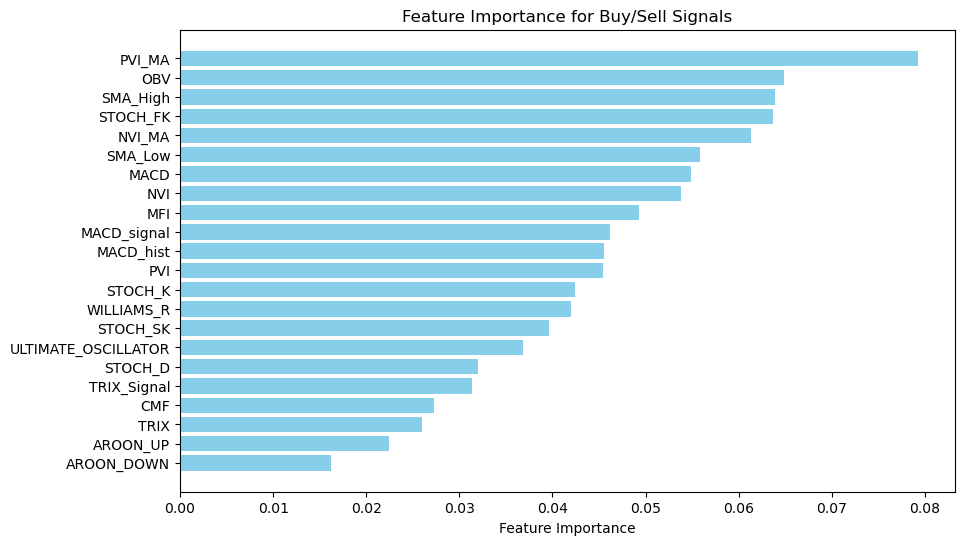

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract the trained classifier from the pipeline
clf = grid_search.best_estimator_.named_steps['clf']

# Get feature importance from the trained model
feature_importance = clf.feature_importances_

# Get the feature names from your input data
feature_names = X_train.columns  # Ensure you use the correct DataFrame or array here

# Create a DataFrame for better readability and sorting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort the DataFrame by importance for better visualization
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Buy/Sell Signals")
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important feature at the top
plt.show()


<h1>Optimal RSI Buy and RSI sell threshholds</h1>
<p>Maximizing the Sharpe Ratio or Cumulative Returns</p>
<h4>Hypothesis:</h4>
<p>Instead of using fixed levels ( RSI 30 for buy and RSI 70 for sell), aim to optimize these threshholds to improve the strategy's performance over historical data.</p>

In [ ]:
from IPython.display import display, Javascript
display(Javascript("IPython.notebook.kernel.restart()"))

In [ ]:
# Back Testing 
# Sharpe Ratio
# Maximum Drawdown
# Cumulative Return

import backtrader as bt
import yfinance as yf
import pandas as pd

class Backtest:
    """
    A class to handle backtesting using Backtrader.
    
    Attributes:
        strategy (bt.Strategy): The strategy class to be tested.
        data (pd.DataFrame): The historical data to be used for backtesting.
        cash (float): The initial capital.
        commission (float): The commission per trade.

    Methods:
        run_backtest(): Sets up the backtest and returns the cerebro engine for further analysis or plotting.
        plot_results(): Plots the results of the backtest using BackTrader's built in plot functionality.
        
    """
    
    def __init__(self, strategy, data, cash=10000, commission=0.001):
        """
        Initialize the Backtest class with strategy, data, cash, and commission.
        
        Parameters:
            strategy (bt.Strategy): A Backtrader strategy class.
            data (pd.DataFrame): Historical market data for backtesting.
            cash (float): Initial cash for backtesting. Default is 10,000.
            commission (float): Commission per trade. Default is 0.1%.
        """
        self.strategy = strategy
        self.data = data
        self.cash = cash
        self.commission = commission

    def run_backtest(self, **kwargs):
        """
        Execute the backtest with the provided strategy and data.

        Parameters: 
            **kwargs: Arguments to override the strategy parameters.
        
        Returns:
            cerebro: The Backtrader engine instance with the run results.
        """
        cerebro = bt.Cerebro()

        # Add the strategy to Cerebro
        cerebro.addstrategy(self.strategy)

        # Convert the DataFrame to Backtrader Data Feed
        data_feed = bt.feeds.PandasData(dataname=self.data)
        cerebro.adddata(data_feed)

        # Set initial cash
        cerebro.broker.setcash(self.cash)

        # Set commission
        cerebro.broker.setcommission(commission=self.commission)

        # Run the backtest
        results = cerebro.run()

        # Return the engine instance for further analysis or plotting
        return cerebro, results

    def plot_results(self, cerebro):
        """
        Plot the results of the backtest.
        
        Parameters:
            cerebro: The Backtrader engine instance with the run results.
        """
        cerebro.plot(style='candlestick')

class RSI_Strategy(bt.Strategy):
    """
    A simple RSI-based trading strategy.
    
    Attributes:
        rsi_period (int): The period for calculating RSI.
        rsi_buy (int): The RSI threshold for buying.
        rsi_sell (int): The RSI threshold for selling.

    Methods:
        next(): This method is called for every time step (data point).
    """
    
    params = (
        ('rsi_period', 14),  # Default RSI period
        ('rsi_buy', 30),     # Default RSI buy threshold
        ('rsi_sell', 70),    # Default RSI sell threshold
    )

    def __init__(self):
        """
        Initialize the strategy and indicators.
        """
        self.rsi = bt.indicators.RelativeStrengthIndex(self.data.close, period=self.params.rsi_period)

    def next(self):
        """
        This method is called on every time step (new data point) to evaluate
        the trading logic.
        """
        # Check if there are no open positions
        if not self.position:
            # Buy condition: RSI below the buy threshold
            if self.rsi < self.params.rsi_buy:
                self.buy()
        
        # Check if there is an open position
        else:
            # Sell condition: RSI above the sell threshold
            if self.rsi > self.params.rsi_sell:
                self.sell()

class SSL_RSI_Strategy(bt.Strategy):
    params = (
        ('ssl_period', 10),  # Period for the moving averages used in SSL
        ('rsi_period', 14),  # RSI period
        ('rsi_buy', 30),     # RSI level to buy
        ('rsi_sell', 70),    # RSI level to sell
    )

    def __init__(self):
        # SSL Semaphore Signal: Moving Average crossovers
        self.sma_high = bt.indicators.SimpleMovingAverage(self.data.high, period=self.params.ssl_period)
        self.sma_low = bt.indicators.SimpleMovingAverage(self.data.low, period=self.params.ssl_period)

        # RSI Indicator
        self.rsi = bt.indicators.RelativeStrengthIndex(self.data.close, period=self.params.rsi_period)

    def next(self):
        # Generate SSL-based buy and sell signals
        if not self.position:  # No open positions
            # Buy condition: price above SSL and RSI confirms oversold
            if self.data.close > self.sma_high and self.rsi < self.params.rsi_buy:
                self.buy()
        
        elif self.position:
            # Sell condition: price below SSL and RSI confirms overbought
            if self.data.close < self.sma_low and self.rsi > self.params.rsi_sell:
                self.sell()

class SSL_RSI_ATR_Strategy(bt.Strategy):
    """
    A strategy using SSL Semaphore Signal and RSI, with ATR for dynamic risk management.
    """

    params = (
        ('ssl_period', 41),       
        ('rsi_period', 13),       
        ('rsi_buy', 41),          
        ('rsi_sell', 74),         
        ('atr_period', 14),       
        ('atr_multiplier', 2.0),  
    )

    def __init__(self):
        # SSL Semaphore Signal
        self.sma_high = bt.indicators.SimpleMovingAverage(self.data.high, period=self.params.ssl_period)
        self.sma_low = bt.indicators.SimpleMovingAverage(self.data.low, period=self.params.ssl_period)

        # RSI Indicator
        self.rsi = bt.indicators.RelativeStrengthIndex(self.data.close, period=self.params.rsi_period)

        # ATR Indicator
        self.atr = bt.indicators.AverageTrueRange(self.data, period=self.params.atr_period)

        # Track buy price
        self.buy_price = None

    def next(self):
        #DEBUGGING
        # Debugging: Print the values of the indicators to check if they make sense
        print(f"Close: {self.data.close[0]}, SMA High: {self.sma_high[0]}, SMA Low: {self.sma_low[0]}, RSI: {self.rsi[0]}, ATR: {self.atr[0]}")
        
        # If no position is open
        if not self.position:
            #RSI DEBUG
            if self.rsi < self.params.rsi_buy:
                print(f"BUY RSI: {self.rsi}, Params: {self.params.rsi_buy}")
            elif self.rsi > self.params.rsi_sell:
                print(f"SELL RSI: {self.rsi}, Params: {self.params.rsi_sell}")

            #SSL DEBUG
            if self.data.close > self.sma_high:
                print(f"BUY SSL")
            elif self.data.close < self.sma_low:
                print(f"SELL SSL")
                
            # Buy if price is above SSL and RSI is below buy threshold
            if self.data.close > self.sma_high and self.rsi < self.params.rsi_buy:
                self.buy()
                self.buy_price = self.data.close[0]  # Track buy price
                print(f"Buy Order Placed at {self.buy_price}")
        
        # If a position is open, use the external ATR-based risk management
        else:
            manage_atr_risk(self, self.buy_price, self.atr[0], self.data.close[0], self.params.atr_multiplier)
            print(f"Managing Position: Current Price: {self.data.close[0]}, Buy Price: {self.buy_price}")
    

def fetch_data(ticker, start_date, end_date):
    """
    Fetch historical data using Yahoo Finance.
    
    Parameters:
        ticker (str): The stock ticker symbol (e.g., 'AAPL').
        start_date (str): The start date for the data in 'YYYY-MM-DD' format.
        end_date (str): The end date for the data in 'YYYY-MM-DD' format.
    
    Returns:
        pd.DataFrame: The historical data.
    """
    return yf.download(ticker, start=start_date, end=end_date)

def manage_atr_risk(strategy, buy_price, atr, current_price, atr_multiplier=2.0):
    """
    Manage risk using ATR-based stop loss and take profit levels.
    
    Parameters:
        strategy (bt.Strategy): The strategy instance (used for buying/selling).
        buy_price (float): The price at which the position was bought.
        atr (float): The current ATR value.
        current_price (float): The current market price.
        atr_multiplier (float): The multiplier for setting stop loss/take profit levels.
        
    Returns:
        None
    """
    # Calculate take profit and stop loss levels based on ATR
    take_profit_price = buy_price + atr * atr_multiplier
    stop_loss_price = buy_price - atr * atr_multiplier

    # Take profit condition
    if current_price >= take_profit_price:
        strategy.sell()  # Execute a sell order
        strategy.buy_price = None  # Reset buy price after selling

    # Stop loss condition
    elif current_price <= stop_loss_price:
        strategy.sell()  # Execute a sell order
        strategy.buy_price = None  # Reset buy price after selling


def run_rsi_backtest(ticker, rsi_buy=30, rsi_sell=70, rsi_period=21):
    """
    Run a backtest on the specified ticker with the given RSI thresholds.
    
    Parameters:
        ticker (str): The stock ticker symbol (e.g., 'AAPL').
        rsi_buy (int): The RSI level below which to buy.
        rsi_sell (int): The RSI level above which to sell.
    
    Returns:
        cerebro: The Backtrader engine instance with the run results.
    """
    # Fetch historical data
    data = fetch_data(ticker, '2010-01-01', '2024-09-09')

    # Define the RSI strategy with the chosen buy and sell levels
    strategy = RSI_Strategy
    
    # Create the backtest with the chosen strategy and data
    backtest = Backtest(strategy, data)

    # Run the backtest
    cerebro, results = backtest.run_backtest(rsi_buy=rsi_buy, rsi_sell=rsi_sell, rsi_period=rsi_period)

    # Get the initial and final portfolio values directly from Backtrader
    initial_value = backtest.cash  # Initial value is the cash we started with
    final_value = cerebro.broker.getvalue()  # Final portfolio value after the backtest

    # Calculate cumulative return
    cumulative_return = (final_value - initial_value) / initial_value * 100  # In percentage

    # Calculate Sharpe Ratio (you can refine this calculation)
    sharpe_ratio = (final_value - initial_value) / (data['Close'].std() * len(data) ** 0.5)  # Simple Sharpe Ratio

    # Maximum Drawdown
    # Extract portfolio values for maximum drawdown calculation
    portfolio_values = [x.broker.getvalue() for x in results]

    # Compute maximum drawdown
    if portfolio_values:  # Ensure portfolio_values is not empty
        max_drawdown = (1 - min(portfolio_values) / max(portfolio_values)) * 100  # In percentage
    else:
        max_drawdown = 0  # No data, set drawdown to 0


    # Plot the results
    backtest.plot_results(cerebro)

    return {
        'cumulative_return': cumulative_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'final_value': final_value
    }

def run_ssl_rsi_atr_backtest(ticker, ssl_period=10, rsi_period=14, rsi_buy=30, rsi_sell=70, atr_period=14, atr_multiplier=2.0):
    """
    Run a backtest on the specified ticker using both SSL and RSI strategies.
    
    Parameters:
        ticker (str): The stock ticker symbol (e.g., 'AAPL').
        ssl_period (int): The period for the SSL Semaphore Signal (moving averages).
        rsi_period (int): The period for calculating the RSI indicator.
        rsi_buy (int): The RSI level below which to buy.
        rsi_sell (int): The RSI level above which to sell.
    
    Returns:
        dict: A dictionary containing performance metrics (cumulative return, Sharpe ratio, final value).
    """
    # Fetch historical data
    data = fetch_data(ticker, '2010-01-01', '2024-09-09')

    # Define the combined SSL and RSI strategy with the chosen parameters
    strategy = SSL_RSI_ATR_Strategy

    # Create the backtest with the chosen strategy and data
    backtest = Backtest(strategy, data, cash=50000, commission=0.001)

    # Run the backtest
    cerebro, results = backtest.run_backtest(ssl_period=ssl_period, 
                                             rsi_period=rsi_period, 
                                             rsi_buy=rsi_buy, 
                                             rsi_sell=rsi_sell,
                                             atr_period=atr_period,
                                             atr_multiplier=atr_multiplier)

    # Get the initial and final portfolio values directly from Backtrader
    initial_value = backtest.cash  # Initial value is the cash we started with
    final_value = cerebro.broker.getvalue()  # Final portfolio value after the backtest

    # Calculate cumulative return
    cumulative_return = (final_value - initial_value) / initial_value * 100  # In percentage

    # Calculate Sharpe Ratio (you can refine this calculation)
    daily_returns = data['Close'].pct_change().dropna()
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * (252 ** 0.5)  # Annualized Sharpe Ratio

    # Maximum Drawdown
    # Extract portfolio values for maximum drawdown calculation
    portfolio_values = [x.broker.getvalue() for x in results]

    # Compute maximum drawdown
    if portfolio_values:  # Ensure portfolio_values is not empty
        max_drawdown = (1 - min(portfolio_values) / max(portfolio_values)) * 100  # In percentage
    else:
        max_drawdown = 0  # No data, set drawdown to 0

    # Plot the results
    backtest.plot_results(cerebro)

    return {
        'cumulative_return': cumulative_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'final_value': final_value
    }



<h2>Correlation between the SSL and RSI Indicators</h2>

<p>Experience conflicting signals between SSL and RSI. They appear to be uncorrelated. RSI is signaling a buy while the SSL is signaling a sell. RSI is oscillatory measuring momentum and SSL is trend following. Contradiction occurs in volatile markets.</p>

In [ ]:
import talib

corr_df = fetch_data('NVDA', '2010-01-01', '2024-09-09')
corr_df.dropna(inplace=True)

corr_df['RSI'] = talib.RSI(corr_df['Close'], timeperiod=14)
corr_df['SMA_High'] = talib.SMA(corr_df['High'], timeperiod=21)
corr_df['SMA_Low'] = talib.SMA(corr_df['Low'], timeperiod=21)

correlation_matrix = corr_df[['RSI', 'SMA_High', 'SMA_Low']].corr()
print("Correlation Matrix")
print(correlation_matrix)

In [ ]:
# Example usage to run the backtest and output results:
results = run_ssl_rsi_atr_backtest('NVDA', ssl_period=41, rsi_period=13, rsi_buy=41, rsi_sell=74, atr_period=14, atr_multiplier=2.0)

# Output the results
print(f"Cumulative Return: {results['cumulative_return']:.2f}%")
print(f"Sharpe Ratio: {results['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {results['max_drawdown']:.2f}%")
print(f"Final Portfolio Value: ${results['final_value']:.2f}")

<h2>Grid Search</h2>

In [ ]:
# RSI levels as hyperparameters that need to be optimized, similar to how hyperparameters are tuned. 
# Grid Search 

import itertools

# Define the range of RSI buy and sell levels to test
rsi_buy_levels = range(10, 50, 5)  # Buy if RSI < level (e.g., 10, 15, 20, ..., 45)
rsi_sell_levels = range(50, 90, 5)  # Sell if RSI > level (e.g., 50, 55, 60, ..., 85)

results = [] 

# Iterate over all combinations of RSI levels
for buy_level, sell_level in itertools.product(rsi_buy_levels, rsi_sell_levels):
    print(f"Testing Buy RSI: {buy_level}, Sell RSI: {sell_level}")
    performance = run_rsi_backtest('NVDA', rsi_buy=buy_level, rsi_sell=sell_level)

    # Store the performance metrics
    results.append({'buy_level': buy_level, 
                    'sell_level': sell_level, 
                    'performance': performance,
                    'cumulative_return': performance['cumulative_return'],
                    'sharpe_ratio': performance['sharpe_ratio'],
                    'final_value': performance['final_value']})

# Print the results
for result in results:
    print(result)

In [ ]:
# Optimize and Tune as needed

# Sort the results by Sharpe Ratio or Cumulative Return
# For Sharpe Ratio:
best_result_by_sharpe = max(results, key=lambda x: x['sharpe_ratio'])

# For Cumulative Return:
best_result_by_return = max(results, key=lambda x: x['cumulative_return'])

# Print the optimal RSI levels and their performance (by Sharpe Ratio)
print(f"Optimal Buy Level (Sharpe): {best_result_by_sharpe['buy_level']}, Optimal Sell Level (Sharpe): {best_result_by_sharpe['sell_level']}")
print(f"Sharpe Ratio: {best_result_by_sharpe['sharpe_ratio']}")
print(f"Cumulative Return: {best_result_by_sharpe['cumulative_return']}")
print(f"Final Portfolio Value: {best_result_by_sharpe['final_value']}")



<h2>Bayseian Optimization RSI</h2>
<p> A method that balances exploration and exploitation. It uses past performance to build a model (usually a Gaussian Process) and directs it search toward more promising areas of the search space. </p>

In [ ]:
from skopt import gp_minimize
from skopt.space import Integer
import numpy as np

# Define the objective function for Bayesian optimization
def objective(params):
    rsi_buy, rsi_sell, rsi_period = params
    
    # Run backtest and get the performance metrics
    performance = run_rsi_backtest('NVDA', rsi_buy=rsi_buy, rsi_sell=rsi_sell, rsi_period=rsi_period)
    
    # We want to maximize Sharpe ratio or cumulative return, but `gp_minimize` minimizes by default,
    # so we return the negative of the metric we want to maximize.
    return -performance['sharpe_ratio']  # or -performance['cumulative_return']

# Define the search space for RSI buy and sell levels
search_space = [
    Integer(10, 45, name='rsi_buy'),  # Search between RSI 10 to 45 for buying
    Integer(50, 85, name='rsi_sell'),  # Search between RSI 50 to 85 for selling
    Integer(7, 30, name='rsi_period')  # Search for the best RSI period between 7 and 30
]

# Early stopping parameters
n_calls = 40  # Maximum number of calls
convergence_threshold = 0.01  # Minimum improvement required to continue optimization
early_stop_iteration = 3  # Number of iterations to check for convergence

# Run Bayesian optimization
result = gp_minimize(objective, search_space, n_calls=n_calls, random_state=42)

# Check for early stopping based on improvement
stopped_early = False
for i in range(early_stop_iteration, n_calls):
    current_best = -result.func_vals[i]  # Convert back to positive Sharpe ratio
    previous_best = -result.func_vals[i - early_stop_iteration]

    improvement = abs(current_best - previous_best)
    if improvement < convergence_threshold:
        print(f"Stopping early at iteration {i} due to convergence.")
        stopped_early = True
        break
        
# Get the optimal RSI levels
optimal_rsi_buy = result.x[0]
optimal_rsi_sell = result.x[1]
optimal_rsi_period = result.x[2]

print(f"Optimal RSI Buy Level: {optimal_rsi_buy}")
print(f"Optimal RSI Sell Level: {optimal_rsi_sell}")
print(f"Optimal RSI Period: {optimal_rsi_period}")

# Get the optimal Sharpe ratio or cumulative return
best_sharpe_ratio = -result.fun  # Since we minimized the negative Sharpe ratio, revert it
print(f"Optimal Sharpe Ratio: {best_sharpe_ratio}")

if stopped_early:
    print(f"Bayesian optimization stopped early at iteration {i} due to lack of improvement.")
else:
    print(f"Bayesian optimization completed all {n_calls} iterations.")

<h2>Bayesian Optimization SSL period & RSI threshholds / Periods</h2>
Optimizing the indicators together is best practice. 

In [ ]:
from skopt import gp_minimize
from skopt.space import Integer

# Define the objective function for optimizing both SSL and RSI parameters
def objective(params):
    ssl_period, rsi_period, rsi_buy, rsi_sell = params
    
    # Run backtest and get the performance metrics
    performance = run_ssl_rsi_backtest('NVDA', ssl_period=ssl_period, rsi_period=rsi_period, rsi_buy=rsi_buy, rsi_sell=rsi_sell)
    
    # We want to maximize Sharpe ratio, but `gp_minimize` minimizes by default,
    # so we return the negative of the Sharpe ratio to maximize it.
    return -performance['sharpe_ratio']

# Define the search space for SSL and RSI parameters
search_space = [
    Integer(5, 50, name='ssl_period'),   # SSL period
    Integer(5, 50, name='rsi_period'),   # RSI period
    Integer(10, 50, name='rsi_buy'),     # RSI Buy threshold
    Integer(50, 90, name='rsi_sell')     # RSI Sell threshold
]

# Run Bayesian optimization
result = gp_minimize(objective, search_space, n_calls=30, random_state=42)

# Get the optimal parameters
optimal_ssl_period = result.x[0]
optimal_rsi_period = result.x[1]
optimal_rsi_buy = result.x[2]
optimal_rsi_sell = result.x[3]

print(f"Optimal SSL Period: {optimal_ssl_period}")
print(f"Optimal RSI Period: {optimal_rsi_period}")
print(f"Optimal RSI Buy Level: {optimal_rsi_buy}")
print(f"Optimal RSI Sell Level: {optimal_rsi_sell}")

# Get the best Sharpe ratio
best_sharpe_ratio = -result.fun
print(f"Best Sharpe Ratio: {best_sharpe_ratio}")


In [ ]:
# Implement the SSL Semaphore Indicator for generating buy / sell signals
import talib
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go

def calculate_moving_averages(df, high_col='high', low_col='low', period=10):
    """
    Calculate the moving averages for the high and low prices.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data
    high_col (str): Column name for high prices
    low_col (str): Column name for low prices
    period (int): Period for calculating moving averages

    Returns:
    pd.DataFrame: DataFrame with 'sma_high' and 'sma_low' columns added
    """
    df['sma_high'] = talib.SMA(df[high_col], timeperiod=period)
    df['sma_low'] = talib.SMA(df[low_col], timeperiod=period)
    return df

def generate_ssl_signals(df, close_col='close', sma_high_col='sma_high', sma_low_col='sma_low'):
    """
    Generate buy and sell signals based on crossovers between the closing price
    and the moving averages applied to the high and low prices.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data
    close_col (str): Column name for close prices
    sma_high_col (str): Column name for the high-based moving average
    sma_low_col (str): Column name for the low-based moving average

    Returns:
    pd.DataFrame: DataFrame with 'buy_signal' and 'sell_signal' columns added
    """
    df.loc[:,'buy_signal'] = np.where(df[close_col] > df[sma_high_col], 1, 0)
    df.loc[:,'sell_signal'] = np.where(df[close_col] < df[sma_low_col], -1, 0)
    return df

def plot_ssl_signals(df, close_col='close', sma_high_col='sma_high', sma_low_col='sma_low', buy_signal_col='buy_signal', sell_signal_col='sell_signal', start_date=None, end_date=None):
    """
    Plot the SSL semaphore signals along with the stock price and moving averages.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data
    close_col (str): Column name for close prices
    sma_high_col (str): Column name for the high-based moving average
    sma_low_col (str): Column name for the low-based moving average
    buy_signal_col (str): Column name for buy signals
    sell_signal_col (str): Column name for sell signals
    start_date (str or datetime): Start date for zooming into a particular time range
    end_date (str or datetime): End date for zooming into a particular time range
    """
    plt.figure(figsize=(12, 8))
    
    # Optionally filter the dataframe for the given date range
    if start_date and end_date:
        df = df[(df.index >= start_date) & (df.index <= end_date)]
    
    plt.plot(df[close_col], label='Close Price', color='black')
    plt.plot(df[sma_high_col], label='SMA High', color='green')
    plt.plot(df[sma_low_col], label='SMA Low', color='red')
    
    # Plot buy signals only where buy_signal == 1
    plt.scatter(df.index[df[buy_signal_col] == 1], df[close_col][df[buy_signal_col] == 1], 
                label='Buy Signal', marker='^', color='blue', alpha=1, s=100)
    
    # Plot sell signals only where sell_signal == -1
    plt.scatter(df.index[df[sell_signal_col] == -1], df[close_col][df[sell_signal_col] == -1], 
                label='Sell Signal', marker='v', color='red', alpha=1, s=100)

    plt.title('SSL Semaphore Signal Level')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()




In [ ]:
df = calculate_moving_averages(data)

df_cleaned = df.dropna()
df_cleaned

df_cleaned = generate_ssl_signals(df_cleaned)

plot_ssl_signals(df_cleaned, start_date='2023-10-01', end_date='2024-02-01')

In [ ]:
# Back Testing using Back Trader Object Oriented 
import backtrader as bt
import backtrader.plot as bplot
import backtrader.analyzers as btanalyzers
from datetime import datetime
%matplotlib inline

# Define the SSL Strategy
class SSLStrategy(bt.Strategy):
    def __init__(self):
        # Define the indicators we want to use
        self.sma_high = bt.indicators.SimpleMovingAverage(self.data.high, period=10)
        self.sma_low = bt.indicators.SimpleMovingAverage(self.data.low, period=10)
        self.rsi = bt.indicators.RelativeStrengthIndex(self.data.close, period=14)
        self.macd = bt.indicators.MACD(self.data.close)

    # The next() method is called for every bar (daily, hourly, etc.)
    def next(self):
        # Buy condition: Close price above SMA high, RSI < X, and MACD > Signal
        if self.data.close > self.sma_high and self.rsi < 10 and self.macd.macd > self.macd.signal:
            self.buy()

        # Sell condition: Close price below SMA low, RSI > X, and MACD < Signal
        elif self.data.close < self.sma_low and self.rsi > 50 and self.macd.macd < self.macd.signal:
            self.sell()

# Initialize Backtrader
cerebro = bt.Cerebro()

# Add the SSL Strategy to Backtrader
cerebro.addstrategy(SSLStrategy)

# Convert the pandas DataFrame into Backtrader Data Feed
data_feed = bt.feeds.PandasData(dataname=df_cleaned)

# Add the data feed to Backtrader
cerebro.adddata(data_feed)

# Add analyzers to Backtrader
cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='trade_analyzer')
cerebro.addanalyzer(btanalyzers.Returns, _name='returns')

# Run the backtest
results = cerebro.run()

# Accessing the results of the analyzers
trade_analyzer = results[0].analyzers.trade_analyzer.get_analysis()
returns_analyzer = results[0].analyzers.returns.get_analysis()

# Print the trade analysis
print("Trade Analysis:")
for key, value in trade_analyzer.items():
    print(f"{key}: {value}")

# Print the returns analysis
print("\nReturns Analysis:")
for key, value in returns_analyzer.items():
    print(f"{key}: {value}")



start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 9, 1)

# Generate the plot with Backtrader
cerebro.plot(iplot=False, style='candlestick', volume=True, barup='green', bardown='red',start=start_date, end=end_date)  # This returns a list of figures

# Print trade statistics
print(f"Total Trades: {trade_analyzer.total.closed}")
print(f"Winning Trades: {trade_analyzer.won.total}")
print(f"Losing Trades: {trade_analyzer.lost.total}")
print(f"Total PnL: {trade_analyzer.pnl.net.total}")
print(f"Strike Rate: {trade_analyzer.won.total / trade_analyzer.total.closed * 100:.2f}%")

# Print returns statistics
print(f"Total Return: {returns_analyzer.rnorm100}%")





In [ ]:
# Volume Indicator (On-Balance Volume - OBV)
df_cleaned.loc[:, 'obv'] = talib.OBV(df_cleaned['close'], df_cleaned['volume'])

# Momentum Indicators (RSI and MACD)
df_cleaned.loc[:, 'rsi'] = talib.RSI(df_cleaned['close'], timeperiod=21)

# Assign MACD, signal, and histogram
df_cleaned.loc[:, 'macd'], df_cleaned.loc[:, 'macdsignal'], df_cleaned.loc[:, 'macdhist'] = talib.MACD(df_cleaned['close'], fastperiod=12, slowperiod=26, signalperiod=9)

df_cleaned = df_cleaned.dropna()
df_cleaned

In [ ]:
# Feature engineering
# I attempt to optimize features below
df_cleaned.loc[:, 'rsi_buy'] = (df_cleaned['rsi'] < 30).astype(int)  # Buy if RSI < 30
df_cleaned.loc[:, 'rsi_sell'] = (df_cleaned['rsi'] > 70).astype(int)  # Sell if RSI > 70

df_cleaned = df_cleaned.drop(columns=['buy_signal', 'sell_signal'])

df_cleaned

In [ ]:
# Strategy Implementation
# Signals SSL, Volume, and Momentum
# Define rules for buying, selling, and holding
# RSI, MACD

def generate_trading_signals(df):
    
    # Conditions for buying
    df.loc[:, 'buy'] = np.where((df['rsi'] < 10) & (df['macd'] > df['macdsignal']), 1, 0)
    
    # Conditions for selling
    df.loc[:, 'sell'] = np.where((df['rsi'] > 50) & (df['macd'] < df['macdsignal']), -1, 0)
    
    return df

def generate_macd_signals(df):
    # Conditions for buying
    df.loc[:, 'buy'] = np.where((df['macd'] > df['macdsignal']), 1, 0)
    
    # Conditions for selling
    df.loc[:, 'sell'] = np.where((df['macd'] < df['macdsignal']), -1, 0)
    
    return df

def generate_rsi_signals(df):
    # Conditions for buying
    df.loc[:, 'buy'] = np.where((df['rsi'] < 30), 1, 0)
    
    # Conditions for selling
    df.loc[:, 'sell'] = np.where((df['rsi'] > 50), -1, 0)

    return df
        


df_cleaned = generate_trading_signals(df_cleaned)
df_cleaned

In [ ]:
def plot_macd_rsi(df, start_date=None, end_date=None):
    """
    Plot MACD and RSI with buy and sell signals, and allow zooming by date range.

    Parameters:
    df (pd.DataFrame): DataFrame containing MACD, MACD Signal, buy and sell signals, RSI, etc.
    start_date (str or pd.Timestamp): Start date for the plot (optional)
    end_date (str or pd.Timestamp): End date for the plot (optional)
    """

     # Optionally filter the DataFrame for the given date range
    if start_date and end_date:
        df = df[(df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))]

    # Plotting MACD and Signal line with crossovers
    plt.figure(figsize=(14, 8))

    # Create subplots: 2 rows, 1 column
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Plot MACD and Signal line on the first subplot (ax1)
    ax1.plot(df.index, df['macd'], label='MACD', color='blue')
    ax1.plot(df.index, df['macdsignal'], label='Signal Line', color='orange')

    # Highlight buy and sell signals on MACD plot
    ax1.scatter(df.index[df['buy'] == 1], df['macd'][df['buy'] == 1], label='Buy Signal', marker='^', color='green', s=100)
    ax1.scatter(df.index[df['sell'] == -1], df['macd'][df['sell'] == -1], label='Sell Signal', marker='v', color='red', s=100)

    # Add labels, legend, and title for MACD plot
    ax1.set_title('MACD Crossovers with Buy and Sell Signals')
    ax1.axhline(0, color='black', linestyle='--', linewidth=1)  # Horizontal line at MACD 0
    ax1.set_ylabel('MACD')
    ax1.legend()
    ax1.grid(True)

    # Plot RSI on the second subplot (ax2)
    ax2.plot(df.index, df['rsi'], label='RSI', color='purple')
    ax2.axhline(10, color='green', linestyle='--')  # RSI oversold line
    ax2.axhline(50, color='red', linestyle='--')    # RSI overbought line

    # Add labels, legend, and title for RSI plot
    ax2.set_title('RSI')
    ax2.set_ylabel('RSI')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(True)

    # Tight layout for better spacing
    plt.tight_layout()

    # Show plot
    plt.show()

plot_macd_rsi(df_cleaned, start_date='2023-01-01', end_date='2024-09-01')

In [ ]:
# Export Trade To CSV or Data Frame for futher analysis 

# After running the backtest, you can extract trade data from TradeAnalyzer
trade_list = []

for trade in results[0].analyzers.trade_analyzer.get_analysis().closed:
    trade_data = {
        'Date': trade.dtclose,
        'Entry Price': trade.pricein,
        'Exit Price': trade.priceout,
        'Profit/Loss': trade.pnl,
        'Commission': trade.commission,
        'Size': trade.size
    }
    trade_list.append(trade_data)

# Convert to DataFrame
df_trades = pd.DataFrame(trade_list)
df_trades.head()
